In [4]:
import pandas as pd

# 加载数据
df = pd.read_csv('../../data/processed/tweets_bushfire_related_keywords.csv')

# 查看数据的前几行
df.head()


,_id,author,parent,quoted,mentions,hashtags,depth,node_type,quote_ancestors,tweet_ancestors,...,deidentname,timebucket,horiz_offset,influence_tweet_factor,left,vert_offset,location,vert_correct,cleaned_text,dominant_topic
0,1134575763334680576,108577207,NaN,1.134424e+18,"['108577207', '21475927', '254515782', '341163...","['ausvotes2019', 'auspol']",0,Root,[],[],...,Scott Morrison,2019-05-31 21:30,0.5,0.477121,False,0.795556,"Tasmania, Australia",True,methinks scottmorrisonmp olofdawson scottjakob...,1
1,1163265539247968256,3112695773,NaN,NaN,"['3112695773', '88593058']",[],0,Root,[],[],...,Christopher Mitchell Henson-Svensson,2019-08-19 01:30,0.5,3.471585,False,0.990000,Unknown,True,koala cut tie alan jones significant buyer med...,3
2,1164479471346257921,2960282202,NaN,NaN,"['3459051', '50393960', '17596622', '155065462...","['amazonfire', 'prayfortheamazon']",0,Root,[],[],...,Hans Moreau,2019-08-22 10:00,0.5,0.301030,True,0.572222,Unknown,True,kindly use pay firefighter jet bombardier cl 1...,5
3,1165088032082604038,2233234848,NaN,NaN,['2233234848'],['amazonfires'],0,Root,[],[],...,Amanda Robert Harding-Stokes,2019-08-24 02:15,0.5,0.477121,False,0.785556,Unknown,True,earth talk human done amazonfires,9
4,1170123597802872834,95802989,NaN,NaN,['95802989'],"['stanthorpe', 'qldfires', 'tenterfield', 'nsw...",0,Root,[],[],...,Janet Dixon,2019-09-06 23:45,0.5,1.946943,True,0.755556,Australia,True,givit supporting service responding bushfire e...,5


In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 初始化VADER情绪分析器
analyzer = SentimentIntensityAnalyzer()

# 定义情绪分析函数
def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']  # 返回综合情绪分数（compound score）

# 应用情绪分析函数
df['sentiment'] = df['display_text'].apply(get_sentiment)

# 查看添加了情绪分数的前几行数据
df[['display_text', 'sentiment']].head(20)


,display_text,sentiment
0,Methinks that for @ScottMorrisonMP @OlofDawson...,0.5419
1,Koala has cut ties with Alan Jones. We’re a si...,-0.5574
2,Kindly use or 'pay' for firefighter JETs\n- Bo...,0.1027
3,When the earth talks about what humans have do...,0.0000
4,GIVIT is supporting services responding to bus...,0.7146
5,Apropos of my tweet yesterday about asking my ...,0.1027
6,"Gladys, your state is on fire. #nswfires #qldf...",-0.3400
7,Given that @ScottMorrisonMP’s negligent inacti...,-0.9117
8,"At 12pm there are 55 bush &amp; grass fires, w...",-0.7463
9,This seems to provide an example of inbition o...,-0.0899


In [13]:
# 计算加权情绪分数
def calculate_weighted_sentiment(row):
    influence_factor = row['influence_tweet_factor']
    weighted_sentiment = row['sentiment'] * influence_factor
    return weighted_sentiment

# 应用加权计算
df['weighted_sentiment'] = df.apply(calculate_weighted_sentiment, axis=1)

# 查看添加了加权情绪分数的前几行数据
df[['display_text', 'sentiment', 'weighted_sentiment']].head()


,display_text,sentiment,weighted_sentiment
0,Methinks that for @ScottMorrisonMP @OlofDawson...,0.5419,0.258552
1,Koala has cut ties with Alan Jones. We’re a si...,-0.5574,-1.935062
2,Kindly use or 'pay' for firefighter JETs\n- Bo...,0.1027,0.030916
3,When the earth talks about what humans have do...,0.0000,0.000000
4,GIVIT is supporting services responding to bus...,0.7146,1.391286


In [18]:
# 转换日期列
df['created_at_dt'] = pd.to_datetime(df['created_at_dt'])

# 按日期汇总加权情绪分数
daily_sentiment = df.groupby(df['created_at_dt'].dt.date)['weighted_sentiment'].sum()

# 查看每日的加权情绪分数
daily_sentiment.head()


created_at_dt
2019-05-31    0.258552
2019-08-19   -1.935062
2019-08-22    0.030916
2019-08-24    0.000000
2019-09-06    1.391286
Name: weighted_sentiment, dtype: float64

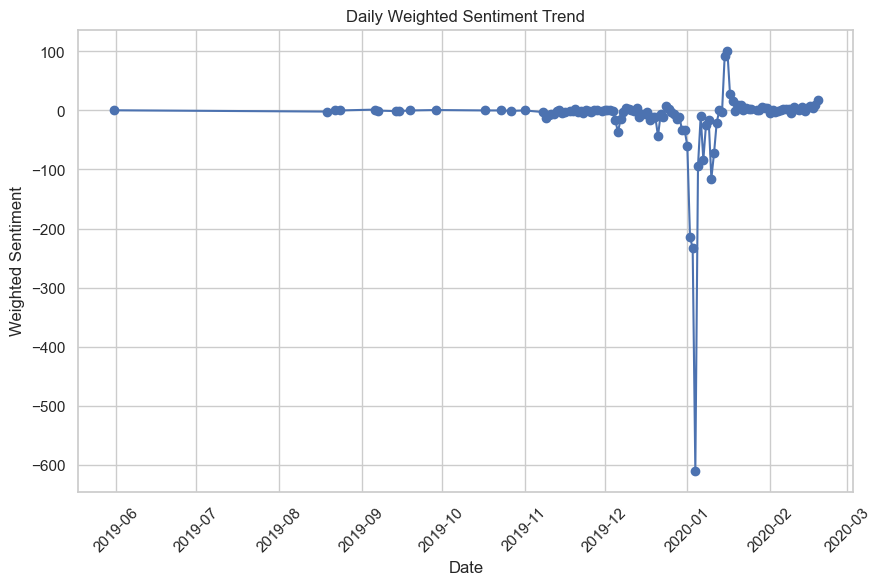

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置Seaborn样式
sns.set(style="whitegrid")

# 绘制每日加权情绪分数的趋势图
plt.figure(figsize=(10, 6))
plt.plot(daily_sentiment.index, daily_sentiment.values, marker='o', linestyle='-', color='b')
plt.title('Daily Weighted Sentiment Trend')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [20]:
# 保存推文的情绪分析结果
# df.to_csv('../../data/processed/tweets_with_sentiment_vader.csv', index=False)

# 保存每日加权情绪分数
# daily_sentiment.to_csv('../../data/processed/daily_weighted_sentiment_vader.csv')

In [27]:
# 保存最终数据
df.to_csv('../../data/processed/final_data.csv', index=False)